In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from  sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay
from feature_engine.encoding import RareLabelEncoder
import joblib as jb

In [7]:
df = pd.read_csv('df_changed.csv')

In [8]:
X = df.drop(['is_canceled'], axis= 1)
y = df['is_canceled']

categorical_variables = X.select_dtypes('object').columns.to_list()
numerical_variables = X.select_dtypes('number').columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 4)

In [9]:
rare_encoder = RareLabelEncoder(tol= 0.003900, variables= ['country'], replace_with= 'Other Country')
rare_encoder.fit(X_train)
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [10]:
categorical_variables

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type']

In [11]:
country_variable = [categorical_variables[2]]

In [12]:
other_variables = []
for i in categorical_variables:
    if i != 'country':
        other_variables.append(i)
    else:
        pass

### Random Forest

In [ ]:
pd.set_option('max_colwidth', None)

other_variables_pipe = Pipeline([('encoder_other_variables', OneHotEncoder(handle_unknown= 'ignore'))])
country_pipe = Pipeline([('encoder_country', OneHotEncoder(handle_unknown= 'ignore'))]) 
num_pipe = Pipeline([('num', StandardScaler())])
   
transformer = ColumnTransformer([('other_variables_transf', other_variables_pipe, other_variables), 
                                 ('country_transf', country_pipe, country_variable), 
                                 ('num_transf', num_pipe, numerical_variables)])

rf = RandomForestClassifier(n_estimators= 100, random_state= 4)

pipe = Pipeline([('transformer', transformer), ('model', rf)])

weights = np.arange(0.2, 0.8, 0.005)
param_grid = {'model__min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 
              'model__class_weight':[{0:x, 1:1-x} for x in weights]}

rscv_rf = RandomizedSearchCV(pipe, param_grid, cv= 10, n_jobs= -1, 
                    scoring= ['recall', 'precision', 'f1', 'roc_auc'], refit= 'f1', return_train_score= True, random_state= 4)

rscv_rf.fit(X_train, y_train)

best_results = pd.DataFrame(rscv_rf.cv_results_)

In [ ]:
best_results[['params','mean_train_recall', 'mean_test_recall', 'mean_train_precision', 'mean_test_precision', 
              'mean_train_f1', 'mean_test_f1', 'mean_train_roc_auc', 'mean_test_roc_auc']].sort_values(
                                                                                'mean_test_f1', ascending= False).round(2)

,params,mean_train_recall,mean_test_recall,mean_train_precision,mean_test_precision,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
4,"{'model__min_samples_leaf': 1, 'model__class_weight': {0: 0.38000000000000017, 1: 0.6199999999999999}}",1.00,0.79,0.99,0.87,0.99,0.83,1.00,0.95
7,"{'model__min_samples_leaf': 4, 'model__class_weight': {0: 0.3950000000000002, 1: 0.6049999999999998}}",0.86,0.80,0.87,0.83,0.87,0.82,0.97,0.94
1,"{'model__min_samples_leaf': 5, 'model__class_weight': {0: 0.2850000000000001, 1: 0.7149999999999999}}",0.92,0.87,0.80,0.76,0.86,0.81,0.97,0.94
5,"{'model__min_samples_leaf': 7, 'model__class_weight': {0: 0.4250000000000002, 1: 0.5749999999999997}}",0.81,0.78,0.86,0.84,0.84,0.81,0.96,0.94
2,"{'model__min_samples_leaf': 10, 'model__class_weight': {0: 0.4150000000000002, 1: 0.5849999999999997}}",0.81,0.78,0.85,0.83,0.83,0.81,0.95,0.93
9,"{'model__min_samples_leaf': 10, 'model__class_weight': {0: 0.25000000000000006, 1: 0.75}}",0.93,0.90,0.72,0.70,0.81,0.79,0.95,0.93
3,"{'model__min_samples_leaf': 10, 'model__class_weight': {0: 0.5500000000000003, 1: 0.44999999999999973}}",0.71,0.69,0.91,0.89,0.79,0.78,0.95,0.93
6,"{'model__min_samples_leaf': 9, 'model__class_weight': {0: 0.6050000000000004, 1: 0.3949999999999996}}",0.67,0.65,0.94,0.92,0.78,0.76,0.95,0.93
8,"{'model__min_samples_leaf': 3, 'model__class_weight': {0: 0.7400000000000004, 1: 0.25999999999999956}}",0.66,0.60,0.99,0.95,0.79,0.74,0.98,0.94
0,"{'model__min_samples_leaf': 7, 'model__class_weight': {0: 0.7700000000000005, 1: 0.22999999999999954}}",0.51,0.49,1.00,0.98,0.68,0.66,0.96,0.94


In [ ]:
print(rscv_rf.best_params_)
print('')

rf_final = rscv_rf.best_estimator_.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

print(classification_report(y_test, y_pred))

{'model__min_samples_leaf': 1, 'model__class_weight': {0: 0.38000000000000017, 1: 0.6199999999999999}}

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     23067
           1       0.87      0.80      0.83     13578

    accuracy                           0.88     36645
   macro avg       0.88      0.87      0.87     36645
weighted avg       0.88      0.88      0.88     36645



### Análise das Features  do modelo 

In [ ]:
feature_importance = pd.Series(rscv_rf.best_estimator_['model'].feature_importances_, 
                               index= rscv_rf.best_estimator_['transformer'].get_feature_names_out())
feature_importance = pd.DataFrame(feature_importance.sort_values(ascending= False).round(2), columns= ['Importance'])
feature_importance.style.bar(color=['red', 'green'])

,Importance
num_transf__lead_time,0.140000
num_transf__adr,0.100000
num_transf__arrival_date_week_number,0.080000
country_transf__country_PRT,0.080000
other_variables_transf__deposit_type_No Deposit,0.060000
num_transf__total_of_special_requests,0.060000
other_variables_transf__deposit_type_Non Refund,0.060000
num_transf__stays_in_week_nights,0.040000
num_transf__stays_in_weekend_nights,0.030000
other_variables_transf__market_segment_Online TA,0.030000


### AdaBoostClassifier | Estimador Base: Decision Tree

In [ ]:
transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown= 'ignore'), categorical_variables), 
                                  ('stdscaler', StandardScaler(), numerical_variables)])

ada_tree = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf= 2, 
                                class_weight= {0:0.645, 1:0.355}, random_state= 4), n_estimators= 100, random_state=4)

pipe = Pipeline([('transformer', transformer), ('model', ada_tree)])

param_grid = {'model__learning_rate': np.arange(1, 1.5, 0.05)}   
    
rscv_ada_tree = RandomizedSearchCV(pipe, param_grid, cv= 10, n_jobs= -1, scoring= ['recall', 'precision', 'f1', 'roc_auc'], 
                             refit= 'f1', return_train_score= True, random_state= 4)

rscv_ada_tree.fit(X_train, y_train)

best_results = pd.DataFrame(rscv_ada_tree.cv_results_)

In [ ]:
pd.set_option('max.colwidth', None)
best_results[['params','mean_train_recall', 'mean_test_recall', 'mean_train_precision', 'mean_test_precision', 
              'mean_train_f1', 'mean_test_f1', 'mean_train_roc_auc', 'mean_test_roc_auc']].sort_values(
                                                                                'mean_test_f1', ascending= False).round(2)

,params,mean_train_recall,mean_test_recall,mean_train_precision,mean_test_precision,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
4,{'model__learning_rate': 1.2000000000000002},0.99,0.77,1.0,0.84,0.99,0.8,1.0,0.92
2,{'model__learning_rate': 1.1},0.99,0.77,1.0,0.84,0.99,0.8,1.0,0.92
1,{'model__learning_rate': 1.05},0.99,0.77,1.0,0.84,0.99,0.8,1.0,0.92
6,{'model__learning_rate': 1.3000000000000003},0.99,0.76,1.0,0.84,0.99,0.8,1.0,0.92
0,{'model__learning_rate': 1.0},0.99,0.76,1.0,0.84,0.99,0.8,1.0,0.91
3,{'model__learning_rate': 1.1500000000000001},0.99,0.76,1.0,0.85,0.99,0.8,1.0,0.92
5,{'model__learning_rate': 1.2500000000000002},0.99,0.76,1.0,0.84,0.99,0.8,1.0,0.92
7,{'model__learning_rate': 1.3500000000000003},0.99,0.77,1.0,0.84,0.99,0.8,1.0,0.92
8,{'model__learning_rate': 1.4000000000000004},0.99,0.76,1.0,0.84,0.99,0.8,1.0,0.92
9,{'model__learning_rate': 1.4500000000000004},0.99,0.76,1.0,0.83,0.99,0.8,1.0,0.92


In [ ]:
print(rscv_ada_tree.best_params_)
print('')

ada_tree_final = rscv_ada_tree.best_estimator_.fit(X_train, y_train)
y_pred = ada_tree_final.predict(X_test)
print(classification_report(y_test, y_pred))

{'model__learning_rate': 1.2000000000000002}

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     23067
           1       0.85      0.77      0.81     13578

    accuracy                           0.87     36645
   macro avg       0.86      0.85      0.85     36645
weighted avg       0.86      0.87      0.86     36645



### GradientBoostingClassifier

In [ ]:
transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown= 'ignore'), categorical_variables), 
                                  ('stdscaler', StandardScaler(), numerical_variables)])

gb = GradientBoostingClassifier(n_estimators= 100, min_samples_leaf= 1,  random_state= 4)

pipe = Pipeline([('transformer', transformer), ('model', gb)])

param_grid = {'model__learning_rate': np.arange(1, 2, 0.2),
              'model__max_depth':[3,5]}   
    
rscv_gb = RandomizedSearchCV(pipe, param_grid, cv= 10, n_jobs= -1, scoring= ['recall', 'precision', 'f1', 'roc_auc'], 
                             refit= 'f1', return_train_score= True, random_state= 4)

rscv_gb.fit(X_train, y_train)

best_results = pd.DataFrame(rscv_gb.cv_results_)

In [ ]:
pd.set_option('max.colwidth', None)
best_results[['params','mean_train_recall', 'mean_test_recall', 'mean_train_precision', 'mean_test_precision', 
              'mean_train_f1', 'mean_test_f1', 'mean_train_roc_auc', 'mean_test_roc_auc']].sort_values(
                                                                                'mean_test_f1', ascending= False).round(2)

,params,mean_train_recall,mean_test_recall,mean_train_precision,mean_test_precision,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
1,"{'model__max_depth': 5, 'model__learning_rate': 1.0}",0.85,0.78,0.89,0.82,0.87,0.80,0.97,0.93
3,"{'model__max_depth': 5, 'model__learning_rate': 1.2}",0.84,0.78,0.88,0.81,0.86,0.80,0.96,0.92
0,"{'model__max_depth': 3, 'model__learning_rate': 1.0}",0.78,0.77,0.85,0.83,0.81,0.79,0.94,0.93
2,"{'model__max_depth': 3, 'model__learning_rate': 1.2}",0.79,0.77,0.85,0.82,0.81,0.79,0.94,0.93
4,"{'model__max_depth': 3, 'model__learning_rate': 1.4}",0.79,0.77,0.84,0.82,0.81,0.79,0.94,0.92
5,"{'model__max_depth': 5, 'model__learning_rate': 1.4}",0.85,0.78,0.88,0.81,0.86,0.79,0.96,0.92
7,"{'model__max_depth': 5, 'model__learning_rate': 1.5999999999999999}",0.83,0.77,0.86,0.80,0.84,0.78,0.95,0.91
6,"{'model__max_depth': 3, 'model__learning_rate': 1.5999999999999999}",0.75,0.74,0.79,0.78,0.76,0.75,0.87,0.86
8,"{'model__max_depth': 3, 'model__learning_rate': 1.7999999999999998}",0.78,0.77,0.73,0.73,0.75,0.75,0.85,0.85
9,"{'model__max_depth': 5, 'model__learning_rate': 1.7999999999999998}",0.76,0.76,0.66,0.65,0.70,0.69,0.74,0.73


In [ ]:
print(rscv_gb.best_params_)
print('')

gb_final = rscv_gb.best_estimator_.fit(X_train, y_train)
y_pred = gb_final.predict(X_test)
print(classification_report(y_test, y_pred))

{'model__max_depth': 5, 'model__learning_rate': 1.0}

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     23067
           1       0.82      0.79      0.81     13578

    accuracy                           0.86     36645
   macro avg       0.85      0.84      0.85     36645
weighted avg       0.86      0.86      0.86     36645



### XGBoostClassifier

In [8]:
scale_pos_weight = df['is_canceled'].value_counts()[0] / df['is_canceled'].value_counts()[1]
print(scale_pos_weight.round(3))

1.704


In [9]:
transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown= 'ignore'), categorical_variables), 
                                  ('stdscaler', StandardScaler(), numerical_variables)])

xgb = XGBClassifier(n_estimator= 100, learning_rate= 1)

pipe = Pipeline([('transformer', transformer), ('model', xgb)])

param_grid = {'model__max_depth':np.arange(5,9),
              'model__scale_pos_weight': np.arange(1.3, 2.3, 0.15)}   
    
rscv_xgb = RandomizedSearchCV(pipe, param_grid, cv= 10, n_jobs= -1, scoring= ['recall', 'precision', 'f1', 'roc_auc'], 
                             refit= 'f1', return_train_score= True, random_state= 4)

rscv_xgb.fit(X_train, y_train)

best_results = pd.DataFrame(rscv_xgb.cv_results_)

[18:22:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



In [10]:
pd.set_option('max.colwidth', None)
best_results[['params','mean_train_recall', 'mean_test_recall', 'mean_train_precision', 'mean_test_precision', 
              'mean_train_f1', 'mean_test_f1', 'mean_train_roc_auc', 'mean_test_roc_auc']].sort_values(
                                                                                'mean_test_f1', ascending= False).round(2)

,params,mean_train_recall,mean_test_recall,mean_train_precision,mean_test_precision,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
4,"{'model__scale_pos_weight': 1.8999999999999997, 'model__max_depth': 8}",0.98,0.83,0.94,0.80,0.96,0.81,1.00,0.94
6,"{'model__scale_pos_weight': 1.7499999999999998, 'model__max_depth': 8}",0.98,0.83,0.95,0.80,0.96,0.81,1.00,0.94
1,"{'model__scale_pos_weight': 1.5999999999999999, 'model__max_depth': 7}",0.95,0.83,0.91,0.80,0.93,0.81,0.99,0.94
3,"{'model__scale_pos_weight': 2.1999999999999993, 'model__max_depth': 8}",0.99,0.84,0.94,0.79,0.96,0.81,1.00,0.94
7,"{'model__scale_pos_weight': 2.1999999999999993, 'model__max_depth': 7}",0.97,0.85,0.89,0.78,0.93,0.81,0.99,0.94
8,"{'model__scale_pos_weight': 1.3, 'model__max_depth': 5}",0.87,0.82,0.86,0.81,0.87,0.81,0.97,0.94
0,"{'model__scale_pos_weight': 2.05, 'model__max_depth': 7}",0.97,0.84,0.90,0.78,0.93,0.81,0.99,0.94
5,"{'model__scale_pos_weight': 1.7499999999999998, 'model__max_depth': 7}",0.96,0.83,0.91,0.79,0.93,0.81,0.99,0.94
2,"{'model__scale_pos_weight': 1.8999999999999997, 'model__max_depth': 6}",0.94,0.84,0.86,0.78,0.90,0.81,0.98,0.93
9,"{'model__scale_pos_weight': 1.7499999999999998, 'model__max_depth': 5}",0.90,0.84,0.83,0.78,0.87,0.81,0.97,0.93


In [12]:
print(rscv_xgb.best_params_)
print('')

xgb_final = rscv_xgb.best_estimator_.fit(X_train, y_train)
y_pred = xgb_final.predict(X_test)
print(classification_report(y_test, y_pred))

{'model__scale_pos_weight': 1.8999999999999997, 'model__max_depth': 8}

[18:22:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

              precision    recall  f1-score   support

           0       0.90      0.87      0.89     23067
           1       0.80      0.84      0.82     13578

    accuracy                           0.86     36645
   macro avg       0.85      0.86      0.85     36645
weighted avg       0.86      0.86      0.86     36645



### VotingClassifier

In [3]:
rf = rf_final
gb = gb_final
xgb = xgb_final
ada_tree = ada_tree_final

In [4]:
voting = VotingClassifier(estimators= [('rf', rf), ('gb', gb), 
                                       ('xgb', xgb), ('ada_tree', ada_tree)], voting= 'soft')

In [17]:
voting_cv = cross_validate(voting, X_train, y_train, cv= 10, n_jobs= -1, 
                            scoring= ['recall', 'precision', 'f1', 'roc_auc'], return_train_score= True)

In [18]:
voting_cv_df = pd.DataFrame(voting_cv)
voting_cv_df.mean().round(2)

fit_time           306.28
score_time           2.64
test_recall          0.81
train_recall         0.99
test_precision       0.86
train_precision      0.99
test_f1              0.83
train_f1             0.99
test_roc_auc         0.95
train_roc_auc        1.00
dtype: float64

In [19]:
voting_final = voting.fit(X_train, y_train)
y_pred = voting_final.predict(X_test)

print(classification_report(y_test, y_pred))

[20:29:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     23067
           1       0.86      0.82      0.84     13578

    accuracy                           0.89     36645
   macro avg       0.88      0.87      0.88     36645
weighted avg       0.88      0.89      0.88     36645



## Comparação

In [ ]:
rf = jb.load('random_forest_model')
gb = jb.load('gradient_boosting_model')
xgb = jb.load('extreme_gradient_boosting_model')
voting = jb.load('voting_classifier_model')
gnb = jb.load('gaussian_nb_model')
logreg = jb.load('logistic_regression_model')
dtree = jb.load('decision_tree_model')
ada_tree = jb.load('ada_tree_model')

In [ ]:
def roc_curve_comparison(models, labels):
    fig, ax = plt.subplots()
    models_labels = zip(models, labels)
    for i, j in models_labels:            
        roc_curve = RocCurveDisplay.from_estimator(i, X_test, y_test, name= j, ax= ax)
    ax.set_title('Comparação de Curvas ROC', fontweight= 'bold', fontsize= 14)    
    ax.set_xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
    ax.set_ylabel('Taxa de Verdadeiros Positivos (Recall)')

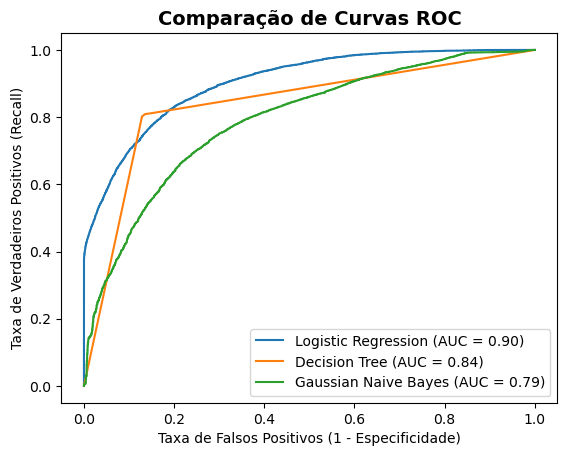

In [ ]:
# Comparação entre os Modelos Base

roc_curve_comparison([logreg, dtree, gnb], 
                     ['Logistic Regression', 'Decision Tree',  'Gaussian Naive Bayes'])

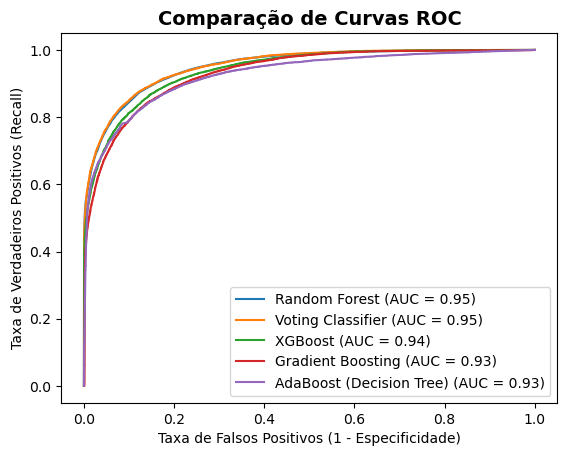

In [ ]:
# Comparação entre os Ensembles

roc_curve_comparison([rf, voting, xgb, gb, ada_tree], 
                     ['Random Forest', 'Voting Classifier', 'XGBoost',  'Gradient Boosting', 'AdaBoost (Decision Tree)'])

In [ ]:
def precision_recall_curve_comparison(models, labels):
    fig, ax = plt.subplots()
    models_labels = zip(models, labels)
    for i, j in models_labels:            
        roc_curve = PrecisionRecallDisplay.from_estimator(i, X_test, y_test, name= j, ax= ax)
        ax.set_title('Comparação Precisão/Recall', fontweight= 'bold', fontsize= 14)
        ax.set_xlabel('Recall/Sensibilidade')
        ax.set_ylabel('Precisão')
        ax.legend(loc= 'lower left')

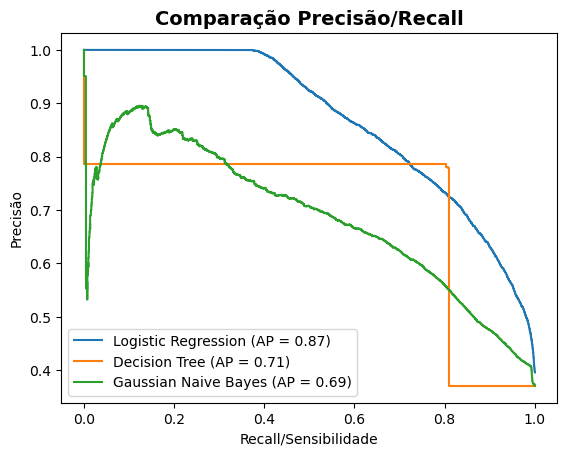

In [ ]:
# Comparação entre os Modelos Base

precision_recall_curve_comparison([logreg, dtree, gnb], 
                                  ['Logistic Regression', 'Decision Tree',  'Gaussian Naive Bayes'])

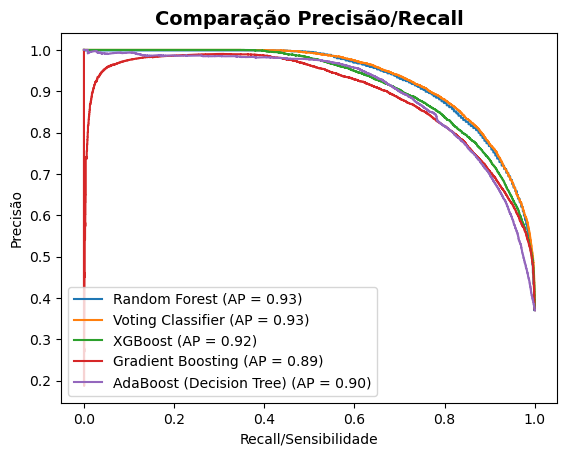

In [ ]:
# Comparação entre os Ensembles


precision_recall_curve_comparison([rf, voting, xgb, gb, ada_tree], 
                                  ['Random Forest', 'Voting Classifier', 'XGBoost',  'Gradient Boosting', 'AdaBoost (Decision Tree)'])

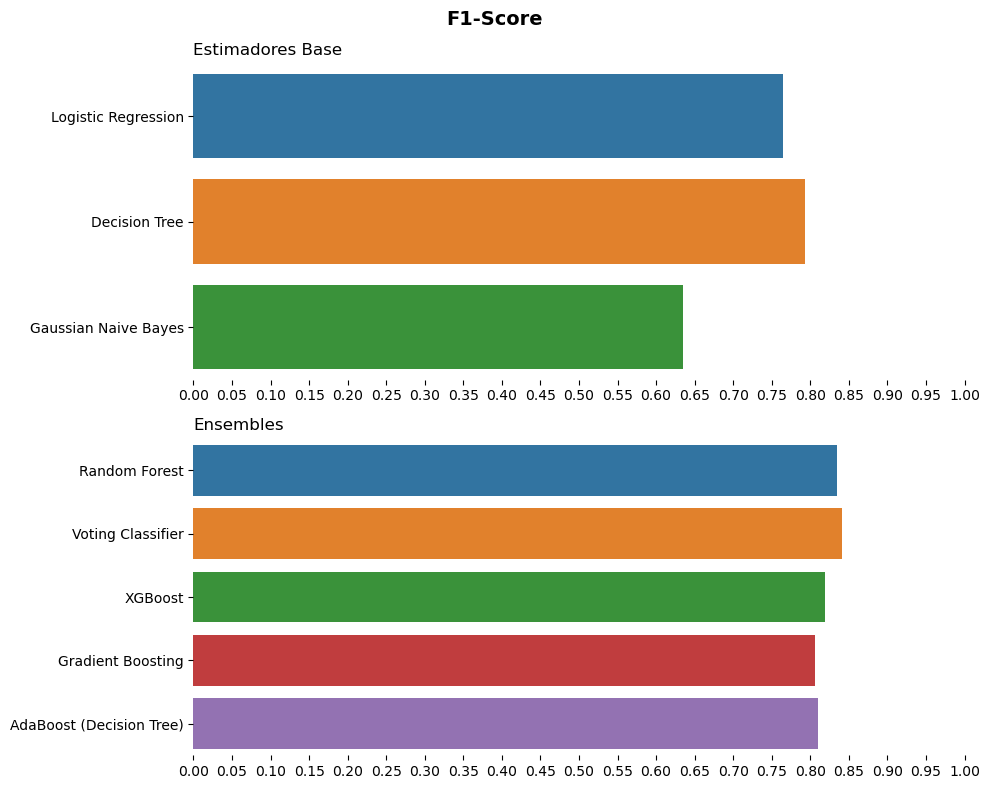

In [ ]:
base_estimators = [logreg, dtree, gnb]
ensemble_estimators = [rf, voting, xgb, gb, ada_tree]

base_estimators_f1_scores = []
ensemble_estimators_f1_scores = []

for i in base_estimators:
    y_pred =  i.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    base_estimators_f1_scores.append(f1)


for i in ensemble_estimators:
    y_pred =  i.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    ensemble_estimators_f1_scores.append(f1)

plt.figure(figsize= (10,8))
plt.suptitle('F1-Score', fontweight= 'bold', fontsize= 14)
plt.subplot(2,1,1)
ax = sns.barplot(x= base_estimators_f1_scores, y= ['Logistic Regression', 'Decision Tree', 'Gaussian Naive Bayes'])
ax.set_title('Estimadores Base', loc= 'left')
ax.set_xticks(np.arange(0,1.05, 0.05))
ax.spines[['top','right', 'left']].set_visible(False)

plt.subplot(2,1,2)
ax2 = sns.barplot(x= ensemble_estimators_f1_scores, 
                 y= ['Random Forest', 'Voting Classifier', 'XGBoost',  'Gradient Boosting', 'AdaBoost (Decision Tree)'])
ax2.set_title('Ensembles', loc= 'left')
ax2.set_xticks(np.arange(0,1.05, 0.05))
ax2.spines[['top','right', 'left']].set_visible(False)

plt.tight_layout()

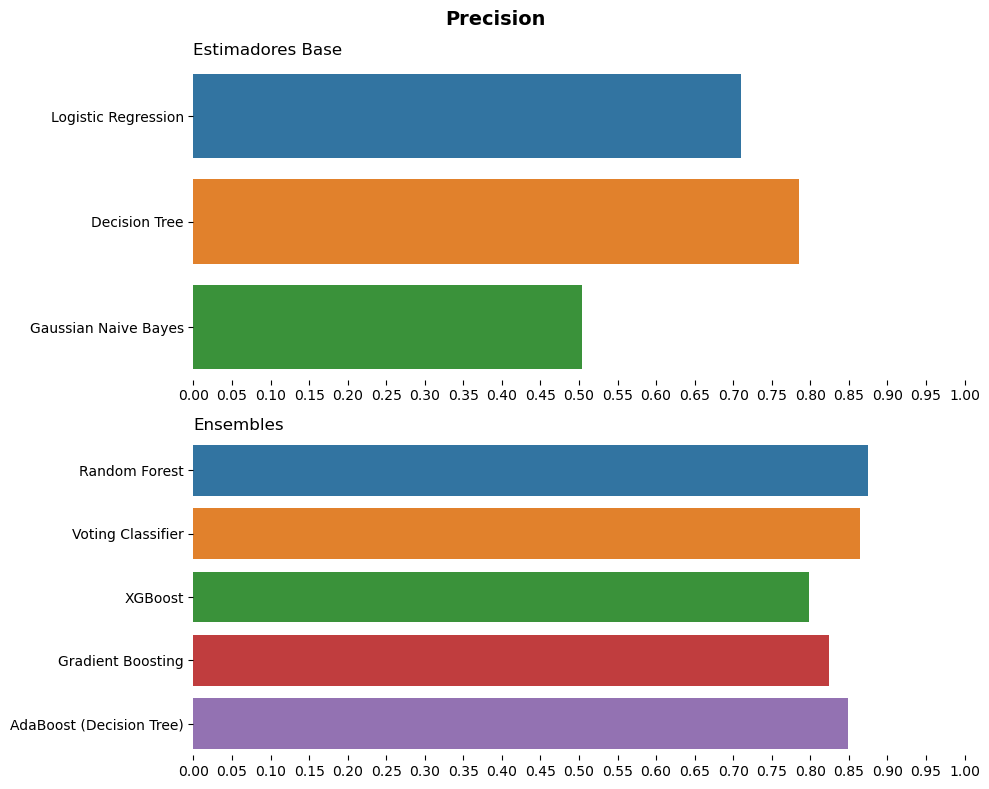

In [ ]:
base_estimators_precision_scores = []
ensemble_estimators_precision_scores = []

for i in base_estimators:
    y_pred =  i.predict(X_test)
    precision = precision_score(y_test, y_pred)
    base_estimators_precision_scores.append(precision)


for i in ensemble_estimators:
    y_pred =  i.predict(X_test)
    precision = precision_score(y_test, y_pred)
    ensemble_estimators_precision_scores.append(precision)

plt.figure(figsize= (10,8))
plt.suptitle('Precision', fontweight= 'bold', fontsize= 14)
plt.subplot(2,1,1)
ax = sns.barplot(x= base_estimators_precision_scores, y= ['Logistic Regression', 'Decision Tree', 'Gaussian Naive Bayes'])
ax.set_title('Estimadores Base', loc= 'left')
ax.set_xticks(np.arange(0,1.05, 0.05))
ax.spines[['top','right', 'left']].set_visible(False)

plt.subplot(2,1,2)
ax2 = sns.barplot(x= ensemble_estimators_precision_scores, 
                 y= ['Random Forest', 'Voting Classifier', 'XGBoost',  'Gradient Boosting', 'AdaBoost (Decision Tree)'])
ax2.set_title('Ensembles', loc= 'left')
ax2.set_xticks(np.arange(0,1.05, 0.05))
ax2.spines[['top','right', 'left']].set_visible(False)

plt.tight_layout()

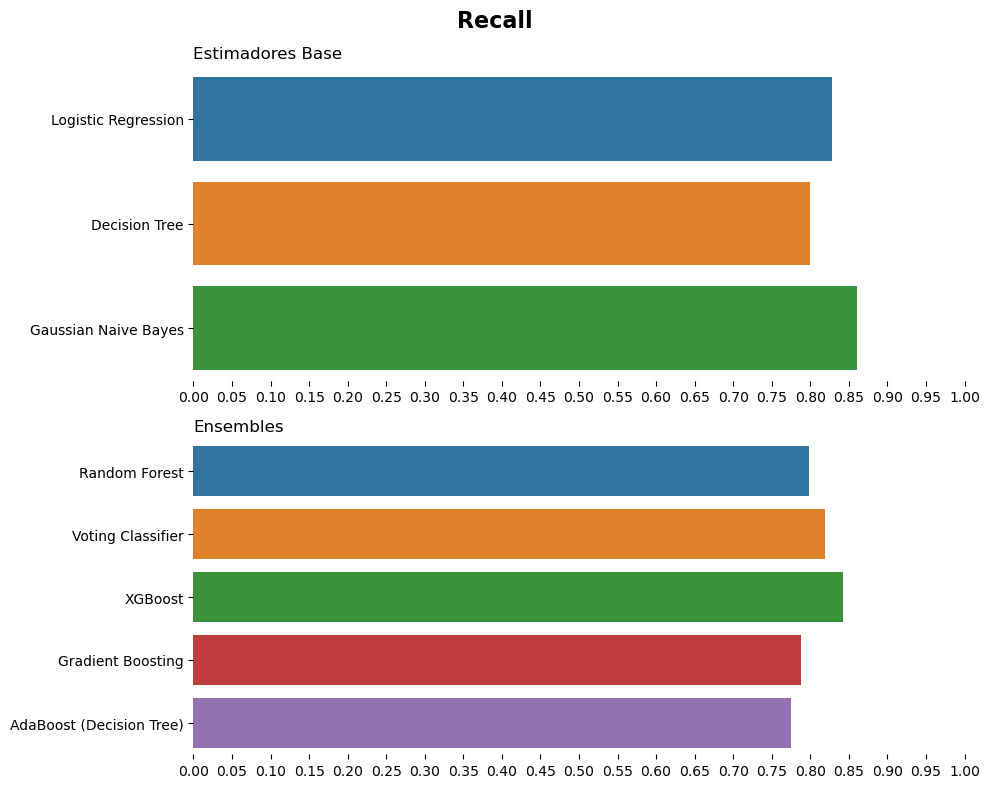

In [ ]:
base_estimators_recall_scores = []
ensemble_estimators_recall_scores = []

for i in base_estimators:
    y_pred =  i.predict(X_test)
    recall = recall_score(y_test, y_pred)
    base_estimators_recall_scores.append(recall)


for i in ensemble_estimators:
    y_pred =  i.predict(X_test)
    recall = recall_score(y_test, y_pred)
    ensemble_estimators_recall_scores.append(recall)

plt.figure(figsize= (10,8))
plt.suptitle('Recall', fontweight= 'bold', fontsize= 16)
plt.subplot(2,1,1)
ax = sns.barplot(x= base_estimators_recall_scores, y= ['Logistic Regression', 'Decision Tree', 'Gaussian Naive Bayes'])
ax.set_title('Estimadores Base', loc= 'left')
ax.set_xticks(np.arange(0,1.05, 0.05))
ax.spines[['top','right', 'left']].set_visible(False)

plt.subplot(2,1,2)
ax2 = sns.barplot(x= ensemble_estimators_recall_scores, 
                 y= ['Random Forest', 'Voting Classifier', 'XGBoost',  'Gradient Boosting', 'AdaBoost (Decision Tree)'])
ax2.set_title('Ensembles', loc= 'left')
ax2.set_xticks(np.arange(0,1.05, 0.05))
ax2.spines[['top','right', 'left']].set_visible(False)

plt.tight_layout()

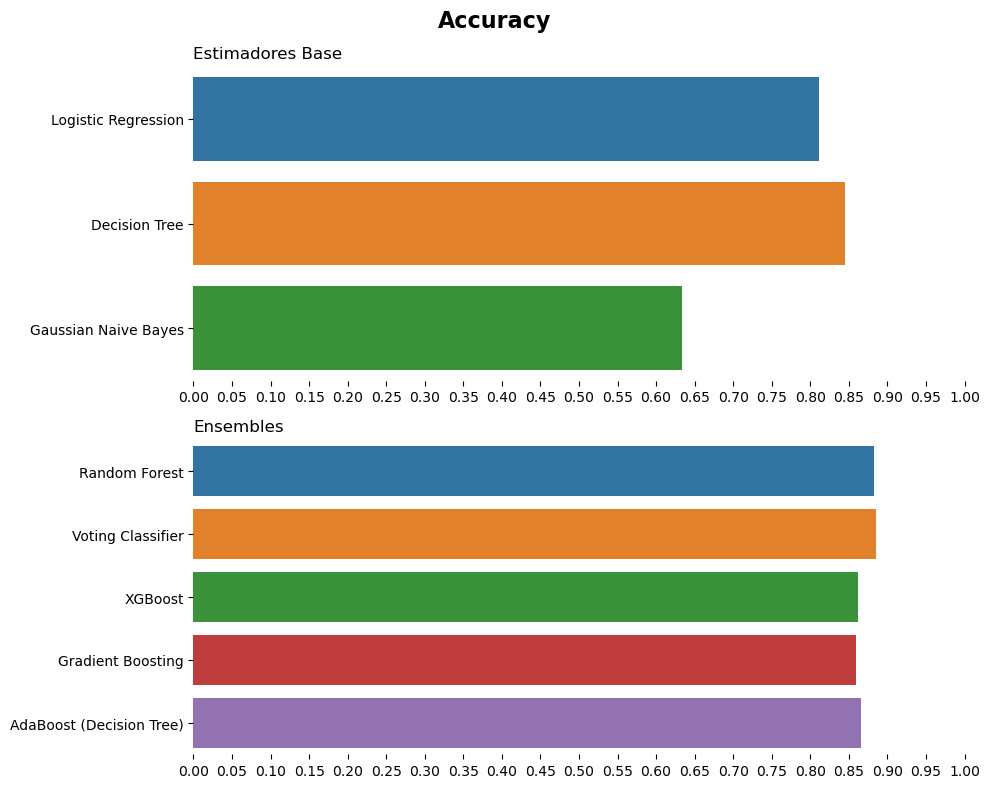

In [ ]:
base_estimators_accuracy_scores = []
ensemble_estimators_accuracy_scores = []

for i in base_estimators:
    y_pred =  i.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    base_estimators_accuracy_scores.append(accuracy)


for i in ensemble_estimators:
    y_pred =  i.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    ensemble_estimators_accuracy_scores.append(accuracy)

plt.figure(figsize= (10,8))
plt.suptitle('Accuracy', fontweight= 'bold', fontsize= 16)
plt.subplot(2,1,1)
ax = sns.barplot(x= base_estimators_accuracy_scores, y= ['Logistic Regression', 'Decision Tree', 'Gaussian Naive Bayes'])
ax.set_title('Estimadores Base', loc= 'left')
ax.set_xticks(np.arange(0,1.05, 0.05))
ax.spines[['top','right', 'left']].set_visible(False)

plt.subplot(2,1,2)
ax2 = sns.barplot(x= ensemble_estimators_accuracy_scores, 
                 y= ['Random Forest', 'Voting Classifier', 'XGBoost',  'Gradient Boosting', 'AdaBoost (Decision Tree)'])
ax2.set_title('Ensembles', loc= 'left')
ax2.set_xticks(np.arange(0,1.05, 0.05))
ax2.spines[['top','right', 'left']].set_visible(False)

plt.tight_layout()